# QOSF Mentorship Screening Task 2


### Author
Tony Tong

### Question
Task 2
Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

#### Bonus
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

### Answer Summary
$$|\psi\rangle=\alpha|00\rangle+\beta|01\rangle+\gamma|10\rangle+\delta|11\rangle$$

$$\left|\beta\right|^{2} = \left|\gamma\right|^{2}$$

Loss Function:
$$\left|\left|\beta\right|^{2} - \left|\gamma\right|^{2}\right|^{2}$$

In [1]:
import pennylane as qml
from pennylane import numpy as np

n_wires = 2

dev = qml.device("default.qubit", analytic=True, wires=2)

In [2]:
# calculation as described above
def opt_theta(d, params, cost):
    params[d] = 0.0
    M_0 = cost(params)
    params[d] = np.pi / 2.0
    M_0_plus = cost(params)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    # restrict output to lie in (-pi,pi], a convention
    # consistent with the Rotosolve paper
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi


# one cycle of rotosolve
def rotosolve_cycle(cost, params):
    for d in range(len(params)):
        opt_theta(d, params, cost)
    return params

In [3]:
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=0)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.probs(wires=[0,1])
    #return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))
    
def cost(params):
    #x, y = circuit(params)
    ps = circuit(params)
    return (abs(ps[1]-0.5))**2 + (abs(ps[2]-0.5))**2 + 10*(abs(ps[0]))**2 + 10*(abs(ps[3]))**2
    #return (abs(x-y))**2

In [4]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [6]:
init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
print(init_params)
params_rsol = init_params.copy()
n_steps = 50

costs_rotosolve = []

for i in range(n_steps):
    costs_rotosolve.append(cost(params_rsol))
    params_rsol = rotosolve_cycle(cost, params_rsol)

[1.4310434178043598, 0.6136235647652082, 1.7943747309799116, -0.2522728019291303]


In [ ]:
params_gd = init_params.copy()
opt = qml.GradientDescentOptimizer(stepsize=0.5)
costs_gd = []
for i in range(n_steps):
    costs_gd.append(cost(params_gd))
    params_gd = opt.step(cost, params_gd)

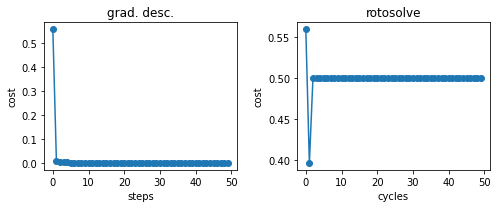

In [8]:
# plot cost function optimization using the 2 techniques
import matplotlib.pyplot as plt

steps = np.arange(0, n_steps)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(steps, costs_gd, "o-")
plt.title("grad. desc.")
plt.xlabel("steps")
plt.ylabel("cost")
plt.subplot(1, 2, 2)
plt.plot(steps, costs_rotosolve, "o-")
plt.title("rotosolve")
plt.xlabel("cycles")
plt.ylabel("cost")
plt.tight_layout()
plt.show()

In [9]:
print(params_rsol)
print(params_gd)
print(circuit(params_rsol))
print(circuit(params_gd))

[3.141592653589793, 0.0, 3.141592653589793, 0.0]
[1.5707963344118372, 0.11242372840322586, 2.3562227760180576, -0.7997822969199591]
[1.40579963e-65 3.74939946e-33 1.00000000e+00 3.74939946e-33]
[0.00160402 0.49839597 0.49839598 0.00160402]
